In [2]:
import os
import sys
sys.path.append("..")  # Add root directory to Python path

import pandas as pd
import yfinance as yf
from configure import FRED_API_KEY
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr

# Setup paths
os.makedirs('../data', exist_ok=True)
os.makedirs('../visuals', exist_ok=True)

In [3]:
# Fetch 5-year data for tech stocks
tech_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
data = yf.download(tech_stocks, period='5y', auto_adjust=True)['Close']
data.to_csv('../data/tech_stocks.csv')
data.head()

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2020-05-04,71.143791,115.799500,65.830269,171.181824,50.745998
2020-05-05,72.211563,115.889999,67.130051,173.019638,51.214001
2020-05-06,72.956619,117.563004,66.951408,174.723404,52.172001
2020-05-07,73.711334,118.380501,68.138237,175.738007,52.002666
2020-05-08,75.465790,118.980499,68.887657,176.771713,54.627998


In [4]:
data.tail()

Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2025-04-28,210.139999,187.699997,160.610001,391.160004,285.880005
2025-04-29,211.210007,187.389999,160.160004,394.040009,292.029999
2025-04-30,212.500000,184.419998,158.800003,395.260010,282.160004
2025-05-01,213.320007,190.199997,161.300003,425.399994,280.519989
2025-05-02,205.350006,189.979996,164.029999,435.279999,287.209991


In [10]:
# Compute Daily Returns
returns = data.pct_change().dropna()
returns.head()  

Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2020-05-05,0.015009,0.000782,0.019744,0.010736,0.009222
2020-05-06,0.010318,0.014436,-0.002661,0.009847,0.018706
2020-05-07,0.010345,0.006954,0.017727,0.005807,-0.003246
2020-05-08,0.023802,0.005068,0.010999,0.005882,0.050485
2020-05-11,0.015735,0.012351,0.013905,0.011155,-0.009922


In [8]:
from pandas_datareader import fred

fed_rate = pdr.get_data_fred(
    'FEDFUNDS',
    start=data.index.min().strftime('%Y-%m-%d'),
    end=data.index.max().strftime('%Y-%m-%d'),
    
)
fed_rate.to_csv('../data/fed_funds_rate.csv')
fed_rate.head()

,FEDFUNDS
DATE,
2020-06-01,0.08
2020-07-01,0.09
2020-08-01,0.10
2020-09-01,0.09
2020-10-01,0.09


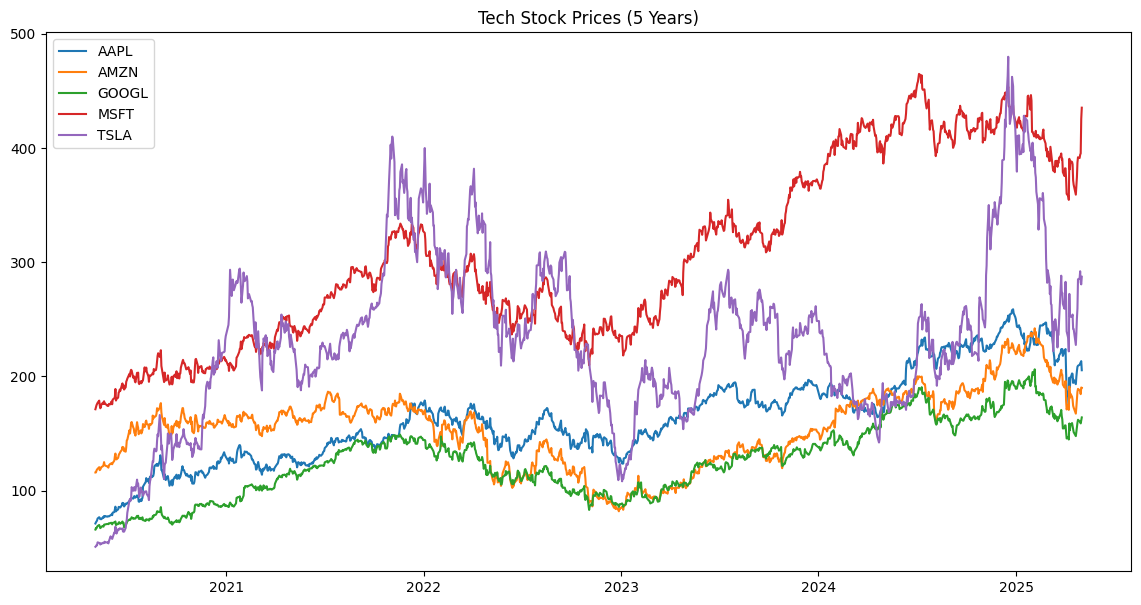

In [9]:
# Plot tech stock prices
plt.figure(figsize=(14, 7))
for stock in data.columns:
    plt.plot(data.index, data[stock], label=stock)
plt.title('Tech Stock Prices (5 Years)')
plt.legend()
plt.savefig('../visuals/price_trends.png', bbox_inches='tight')
plt.show()

In [11]:
# Calculate volatility (standard deviation of returns)
volatility = returns.std() * np.sqrt(252)  # Annualized

C:\Users\abc\AppData\Local\Temp\ipykernel_10648\2120382979.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=volatility.index, y=volatility.values, palette="viridis")


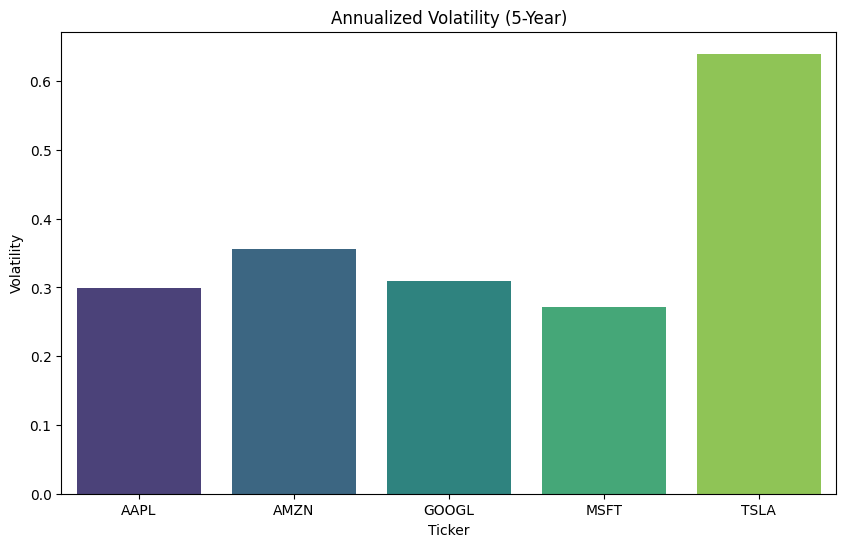

In [12]:
# Plot volatility
plt.figure(figsize=(10, 6))
sns.barplot(x=volatility.index, y=volatility.values, palette="viridis")
plt.title('Annualized Volatility (5-Year)')
plt.ylabel('Volatility')
plt.savefig('../visuals/volatility.png', bbox_inches='tight')
plt.show()

In [14]:
# Load Federal Funds Rate data
fed_rate = pd.read_csv('../data/fed_funds_rate.csv', index_col='DATE', parse_dates=True)

# Merge stock returns and Fed rate
combined_data = pd.concat([returns, fed_rate], axis=1).dropna()
combined_data.columns = list(returns.columns) + ['FED Rate']

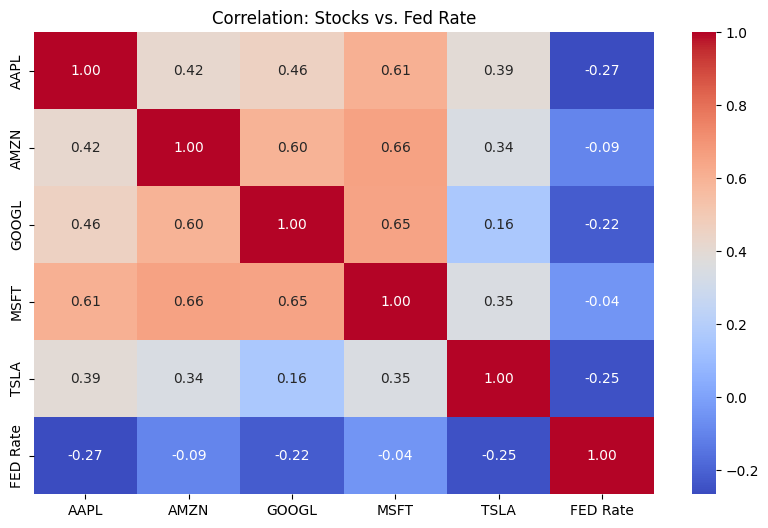

In [16]:
# Calculate correlation
correlation = combined_data.corr()
# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation: Stocks vs. Fed Rate')
plt.savefig('../visuals/macro_correlation.png', bbox_inches='tight')
plt.show()

In [17]:
# Fetch S&P 500 data as market proxy
market = yf.download('SPY', period='5y', auto_adjust=True)['Close']
market_returns = market.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [18]:
# Merge stock returns (e.g., AAPL) with market returns
merged_returns = pd.concat([returns['AAPL'], market_returns], axis=1).dropna()
merged_returns.columns = ['AAPL', 'Market']

In [19]:
import statsmodels.api as sm
# Run regression
X = sm.add_constant(merged_returns['Market'])  # Add intercept
model = sm.OLS(merged_returns['AAPL'], X).fit()
beta = model.params['Market']

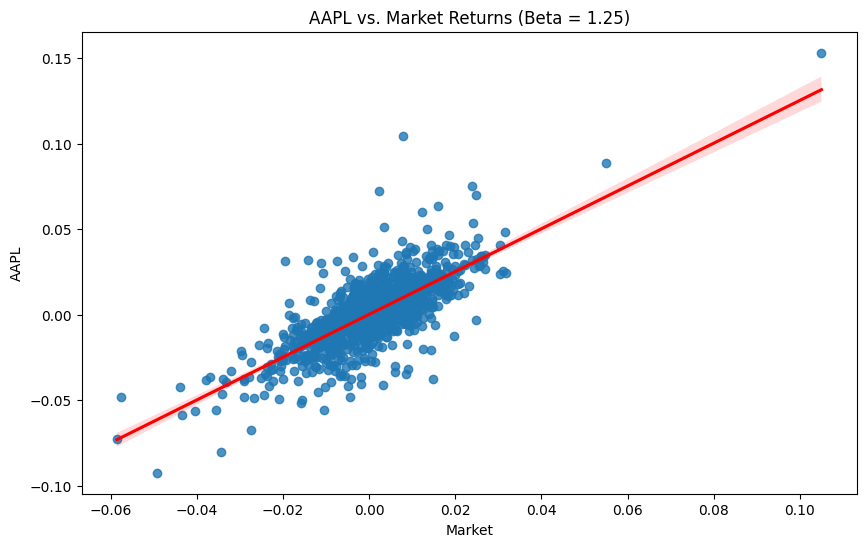

In [20]:
# Plot regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='Market', y='AAPL', data=merged_returns, line_kws={'color': 'red'})
plt.title(f'AAPL vs. Market Returns (Beta = {beta:.2f})')
plt.savefig('../visuals/capm_beta.png', bbox_inches='tight')
plt.show()

In [21]:
# Assume risk-free rate = average Fed rate over 5 years
risk_free_rate = combined_data['FED Rate'].mean() / 100  # Convert from percentage

In [22]:
# Calculate Sharpe Ratio
sharpe_ratio = (returns.mean() * 252 - risk_free_rate) / (returns.std() * np.sqrt(252))

C:\Users\abc\AppData\Local\Temp\ipykernel_10648\3978984036.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sharpe_ratio.index, y=sharpe_ratio.values, palette="rocket")


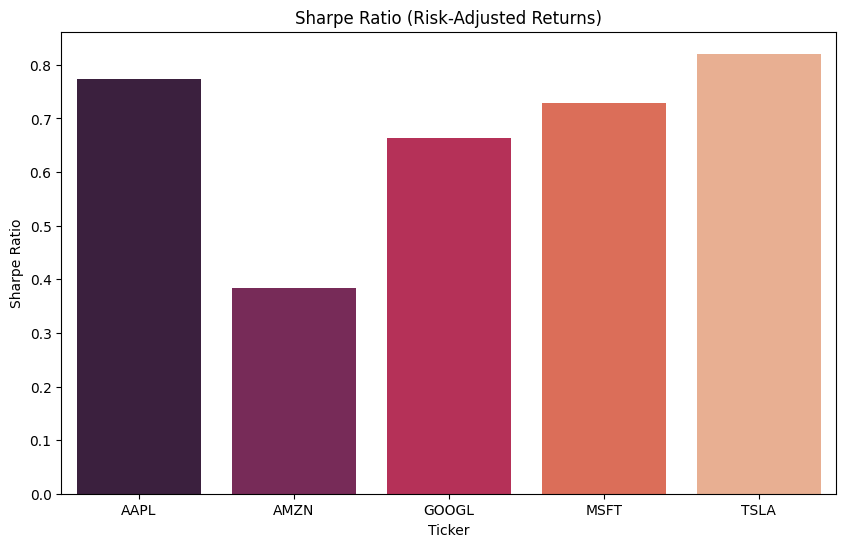

In [23]:
# Plot Sharpe Ratios
plt.figure(figsize=(10, 6))
sns.barplot(x=sharpe_ratio.index, y=sharpe_ratio.values, palette="rocket")
plt.title('Sharpe Ratio (Risk-Adjusted Returns)')
plt.ylabel('Sharpe Ratio')
plt.savefig('../visuals/sharpe_ratio.png', bbox_inches='tight')
plt.show()

In [24]:
# Normalize stock prices and Fed rate for comparison
normalized_prices = data.div(data.iloc[0])  # Start at 1 for easy comparison
normalized_fed_rate = fed_rate / fed_rate.iloc[0]

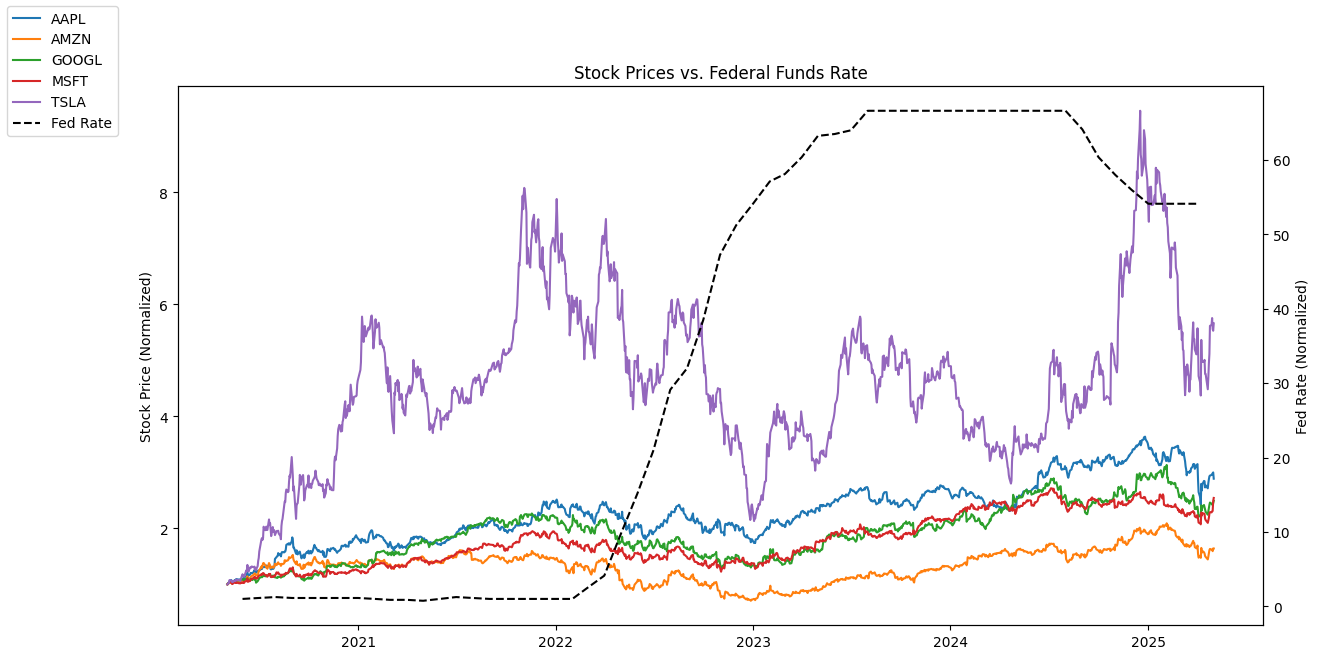

In [26]:
# Plot dual-axis chart
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(normalized_prices.index, normalized_prices, label=normalized_prices.columns)
ax1.set_ylabel('Stock Price (Normalized)')
ax2 = ax1.twinx()
ax2.plot(normalized_fed_rate.index, normalized_fed_rate, color='black', linestyle='--', label='Fed Rate')
ax2.set_ylabel('Fed Rate (Normalized)')
plt.title('Stock Prices vs. Federal Funds Rate')
fig.legend(loc="upper left")
plt.savefig('../visuals/macro_impact.png', bbox_inches='tight')
plt.show()